In [39]:
%matplotlib notebook

In [1]:
import os
from simple_gb.mygb_nikolaev import *
from gb_impl_checker import Checker
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
class SimpleGBTuning(BaseEstimator):
    def __init__(self, iters=100, tau=0.1,
                 criterion="mse",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 presort=False):
        self.iters = iters
        self.tau = tau
        # Tree params
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.presort = presort
        
    def fit(self, X_data, y_data):
        self.base_algo = DecisionTreeRegressor(
            self.criterion,
            self.splitter,
            self.max_depth,
            self.min_samples_split,
            self.min_samples_leaf,
            self.min_weight_fraction_leaf,
            self.max_features,
            self.random_state,
            self.max_leaf_nodes,
            self.min_impurity_decrease,
            self.min_impurity_split,
            self.presort,
        ).fit(X_data, y_data)
        self.estimators = []
        curr_pred = self.base_algo.predict(X_data)
        for iter_num in range(self.iters):
            # Нужно посчитать градиент функции потерь
            grad = expit(curr_pred) - y_data
            # Нужно обучить DecisionTreeRegressor предсказывать антиградиент
            # Не забудьте про self.tree_params_dict
            algo = DecisionTreeRegressor(
                self.criterion,
                self.splitter,
                self.max_depth,
                self.min_samples_split,
                self.min_samples_leaf,
                self.min_weight_fraction_leaf,
                self.max_features,
                self.random_state,
                self.max_leaf_nodes,
                self.min_impurity_decrease,
                self.min_impurity_split,
                self.presort,
            ).fit(X_data, -grad)

            self.estimators.append(algo)
            # Обновите предсказания в каждой точке
            curr_pred += self.tau * algo.predict(X_data)
        return self
    
    def predict(self, X_data):
        # Предсказание на данных
        res = self.base_algo.predict(X_data)
        for estimator in self.estimators:
            res += self.tau * estimator.predict(X_data)
        # Задача классификации, поэтому надо отдавать 0 и 1
        return expit(res) > 0.5

In [3]:
checker = Checker()
data, target = checker.data, checker.target

In [4]:
%%time
estimator = SimpleGB(dict(random_state=42), 100, 0.1)
baseline_score = np.mean(cross_val_score(
                    estimator, data, target,
                    scoring='accuracy', 
                    cv=3
                ))
print('Baseline score {}'.format(baseline_score))

Baseline score 0.6763786890711475
CPU times: user 6.78 s, sys: 41.2 ms, total: 6.82 s
Wall time: 6.82 s


In [5]:
cache = [({'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 25, 'tau': 0.19},0.7807187145809721)]

In [47]:
%%time
param_grid1 = {
    'tau': [0.19,0.2,0.21],
    'max_depth': [6,7,8,9],
    'min_samples_split': [24,25,26,27],
    'min_samples_leaf': [2,3,4],
}

clf = SimpleGBTuning(iters=100, random_state=42)

grid1 = GridSearchCV(clf, param_grid1, scoring='accuracy', n_jobs=-1, cv=3)
grid1.fit(data, target)

print('=====\n'
      'Best params {}\n'
      'Score {} ({})\n'
      '====='.format(
          grid1.best_params_,
          grid1.best_score_, grid1.best_score_ - baseline_score
      ))
cache += grid1.best_params_, grid1.best_score_

=====
Best params {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 25, 'tau': 0.19}
Score 0.7807187145809721 (0.10434002550982457)
=====
CPU times: user 2.3 s, sys: 644 ms, total: 2.94 s
Wall time: 1min 33s


In [5]:
#Check our gradient boosting classifier
checker = Checker()
scores = {}
results = {}
for filename in os.listdir('simple_gb'):
    if filename.endswith('.py'):
        name = '_'.join(filename.split()[0].split('_')[-1:]).strip()
        score = checker.check('simple_gb/' + filename)
        print(name, score)

nikolaev.py 0.7769185037007401


In [6]:
params = {
    'tau': 0.19,
    'max_depth': 8,
    'min_samples_leaf': 3,
    'min_samples_split': 25,
}
clf = SimpleGBTuning(iters=100, random_state=42, **params).fit(data, target)

In [15]:
import pydotplus 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

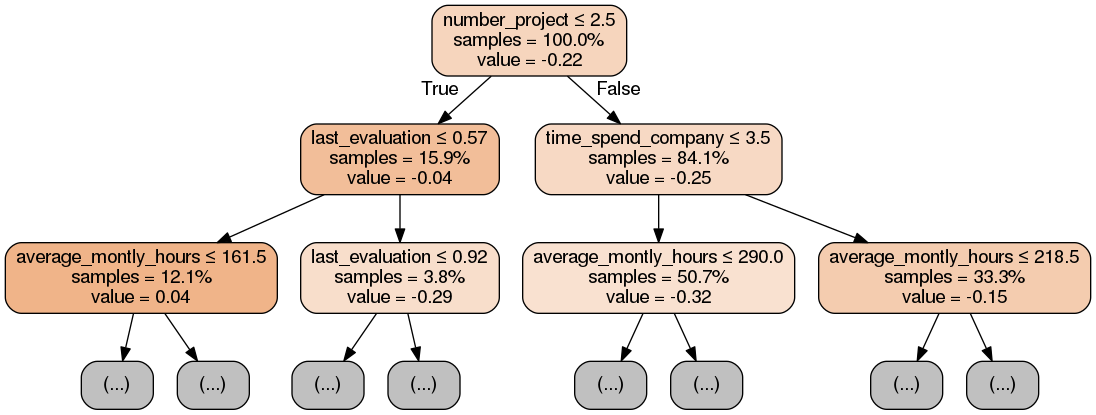

In [16]:
model = clf.estimators[2]

features = ['last_evaluation', 'number_project',
            'average_montly_hours', 'time_spend_company',
            'Work_accident', 'promotion_last_5years']

class_names = ['stayed', 'left']

def plot_tree(model, out_file, max_depth):

    dot_data = tree.export_graphviz(decision_tree=model, out_file=out_file,
                                    max_depth=max_depth,
                                    feature_names=features,
                                    class_names=class_names,
                                    filled=True, rounded=True,  
                                    special_characters=True,
                                    proportion = True, precision=2,
                                    label='all', impurity=False,
                                   )  

    graph = pydotplus.graphviz.graph_from_dot_file(out_file)  
    return Image(graph.create_png())
    
plot_tree(model, out_file="small_tree.out", max_depth=2)

In [29]:
def plot_decision_surface(model, X, y):
    
    """Function to plot the decision boundaries of a classification model.
    
    Adopted from:
    http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """

    plt.figure(figsize=(8,6))
    plt.subplot(1, 1, 1)

    n_classes = 2
    plot_step = 0.02
    plot_colors = ['white', 'tab:blue']
    cmap = plt.cm.Blues
    
    model.fit(X, y)

    d0, d1 = (X[:, 0].max() - X[:, 0].min()) * 0.1, (X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - d0, X[:, 0].max() + d0
    y_min, y_max = X[:, 1].min() - d1, X[:, 1].max() + d1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    print(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    plt.xlabel(c1)
    plt.ylabel(c2)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], cmap=cmap, label=class_names[i],
                    edgecolor='black', s=90, color=color)

    plt.suptitle("Decision surface of a decision tree using paired features")
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    plt.axis("tight")
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    return plt

In [30]:
# c1, c2 = 'average_montly_hours', 'last_evaluation'
c1, c2 = 0, 1

[[ 1.5  -0.1 ]
 [ 1.52 -0.1 ]
 [ 1.54 -0.1 ]
 ...
 [ 7.44  1.1 ]
 [ 7.46  1.1 ]
 [ 7.48  1.1 ]]


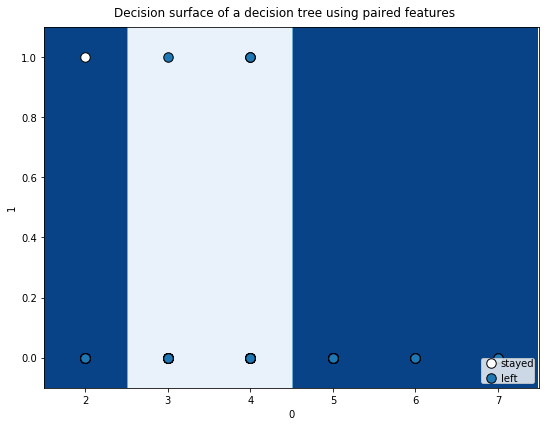

In [37]:
plot_decision_surface(model=clf, X = data[::100, (1,5)], y = target[::100]);

In [46]:
plt.scatter(data[:,0::100],
            data[:,2::100],
            с=['red' if x else 'blue' for x in target[::100]]
           )

<IPython.core.display.Javascript object>

AttributeError: Unknown property с